In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import imshow
import os
from collections import defaultdict
import matplotlib.pyplot as plt

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def RGBtoYCC(arr):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = arr.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [3]:
def YCCtoRGB(arr):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = arr.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [4]:
def RGBtoGray(arr):
    ycc = RGBtoYCC(arr)
    ret = np.zeros_like(ycc)
    ret[:, :, 0] = ycc[:, :, 0]
    ret[:, :, 1] = ycc[:, :, 0]
    ret[:, :, 2] = ycc[:, :, 0]
    return ret

In [5]:
def YCCtoGray(arr):
    ret = np.zeros_like(arr)
    ret[:, :, 0] = arr[:, :, 0]
    ret[:, :, 1] = arr[:, :, 0]
    ret[:, :, 2] = arr[:, :, 0]
    return ret

In [6]:
train_dir = './images/train/'

image_names = os.listdir(train_dir)

%matplotlib inline

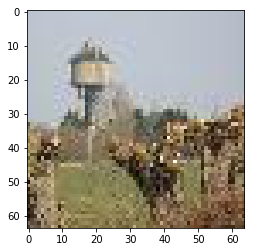

In [7]:
# display an image
filename = 'n04562935_437.JPEG'
im = Image.open(train_dir + filename)
arr = np.array(im)
imshow(arr)

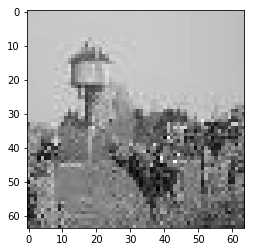

In [8]:
# look at grayscale version
gray_arr = RGBtoGray(arr)
imshow(gray_arr[:, :, 0], cmap='gray')

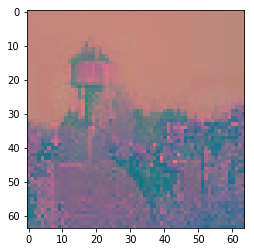

In [9]:
# look at YCC version
ycc_arr = RGBtoYCC(arr)
imshow(ycc_arr)

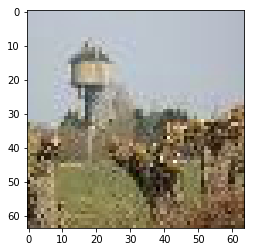

In [10]:
# look at YCC to RGB conversion
back_arr = YCCtoRGB(ycc_arr)
imshow(back_arr)

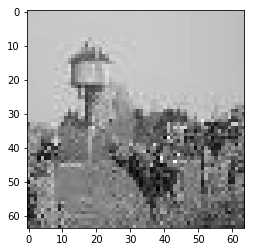

In [11]:
# look at gray YCC version
ycc_gray = YCCtoGray(ycc_arr)
imshow(ycc_gray[:, :, 0], cmap='gray')

In [12]:
# some of the images might not be the right size
# these are the dimenions with which we are working
H = 64
W = 64
C = 3

data = []
count = 0
limit = 5000

for fname in image_names:
    if count >= limit:
        break
    x = np.array(Image.open(os.path.join(train_dir, fname)))
    if x.shape == (H, W, C):
        data.append(RGBtoYCC(x))
        count += 1

data = np.stack(data)
N = data.shape[0]

num_train = 4 * N // 5
num_val = N // 10
num_test = N // 10

data_train = data[:num_train]
data_val = data[num_train : num_train + num_val]
data_test = data[num_train + num_val : num_train + num_val + num_test]

In [13]:
mean_pixel = np.mean(data_train, axis=(0, 1, 2), keepdims=True)
std_pixel = np.std(data_train, axis=(0, 1, 2), keepdims=True)

undo_mean = np.reshape(mean_pixel, (1, 1, C))
undo_std = np.reshape(std_pixel, (1, 1, C))

data_train = (data_train - mean_pixel) / std_pixel
data_val = (data_val - mean_pixel) / std_pixel
data_test = (data_test - mean_pixel) / std_pixel

X_train = []
Y_train = []
for x in data_train:
    gray = YCCtoGray(x)
    X_train.append(gray)
    Y_train.append(x[:, :, 1:])
X_train = np.stack(X_train)
Y_train = np.stack(Y_train)

X_val = []
Y_val = []
for x in data_val:
    gray = YCCtoGray(x)
    X_val.append(gray)
    Y_val.append(x[:, :, 1:])
X_val = np.stack(X_val)
Y_val = np.stack(Y_val)


X_test = []
Y_test = []
for x in data_test:
    gray = YCCtoGray(x)
    X_test.append(gray)
    Y_test.append(x[:, :, 1:])
X_test = np.stack(X_test)
Y_test = np.stack(Y_test)

In [14]:
print(mean_pixel)
print(std_pixel)

[[[[115.24673419 119.52736609 132.7303833 ]]]]
[[[[67.14855842 18.40483422 17.77659684]]]]


In [15]:
# check their sizes
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', Y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', Y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', Y_test.shape)

Train data shape:  (4000, 64, 64, 3)
Train labels shape:  (4000, 64, 64, 2)
Validation data shape:  (500, 64, 64, 3)
Validation labels shape:  (500, 64, 64, 2)
Test data shape:  (500, 64, 64, 3)
Test labels shape:  (500, 64, 64, 2)


In [16]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 10

print('Using device: ', device)

Using device:  /cpu:0


In [ ]:
input_shape = (H, W, C)

def my_loss_function(y_true, y_pred):
    N = tf.shape(y_true)[0]
    y_true = tf.reshape(y_true, (N, -1))
    y_pred = tf.reshape(y_pred, (N, -1))
    square = tf.keras.backend.square(y_true - y_pred)
    summed = tf.keras.backend.sum(square, axis=1)
    meaned = tf.keras.backend.sum(summed, axis=0) / tf.cast(tf.shape(y_true)[0], tf.float32)
    return meaned

# THIS DOES NOT WORK
# model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
#                                    input_shape=input_shape)

# last_layer = model.layers[-1].output
# flat = tf.keras.layers.Flatten()(last_layer)
# out = tf.keras.layers.Dense(W * H * C, activation="relu")(flat)

# custom_vgg = tf.keras.models.Model(inputs=model.inputs, outputs=out)

# custom_vgg.summary()

# sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=.9)
# custom_vgg.compile(loss=my_loss_function, optimizer=sgd)

# custom_vgg.fit(X_train, Y_train,
#            batch_size=32,
#            epochs=1)

# single_test = np.expand_dims(ycc_gray, axis=0)
# predict = VGGmodel.predict(single_test, verbose=True)
# print(predict.shape)

In [21]:
input_shape = (H, W, C)

def my_loss_function(y_true, y_pred):
    N = tf.shape(y_true)[0]
    y_true = tf.reshape(y_true, (N, -1))
    y_pred = tf.reshape(y_pred, (N, -1))
    square = tf.keras.backend.square(y_true - y_pred)
    summed = tf.keras.backend.sum(square, axis=1)
    meaned = tf.keras.backend.sum(summed, axis=0) / tf.cast(tf.shape(y_true)[0], tf.float32)
    return meaned

model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                    input_shape=input_shape)
for layer in model.layers:
    layer.trainable = False

inter_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
inter1 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[0]).output)
inter2 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[1]).output)
inter3 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[2]).output)
inter4 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(inter_layers[3]).output)

inter1_scale = 64 // inter1.output_shape[1]
inter2_scale = 64 // inter2.output_shape[1]
inter3_scale = 64 // inter3.output_shape[1]
inter4_scale = 64 // inter4.output_shape[1]

inter1Up = tf.keras.layers.UpSampling2D(size=inter1_scale)(inter1.output)
inter2Up = tf.keras.layers.UpSampling2D(size=inter2_scale)(inter2.output)
inter3Up = tf.keras.layers.UpSampling2D(size=inter3_scale)(inter3.output)
inter4Up = tf.keras.layers.UpSampling2D(size=inter4_scale)(inter4.output)
# print(inter1Up, inter2Up, inter3Up, inter4Up)

hyper = tf.keras.layers.Concatenate(axis=-1)([inter1Up, inter2Up, inter3Up, inter4Up])
# print(hyper)

hyper = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(hyper)
hyper = tf.keras.layers.BatchNormalization()(hyper)
hyper = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(hyper)
hyper = tf.keras.layers.BatchNormalization()(hyper)
out = tf.keras.layers.Conv2D(2, (3, 3), padding="same")(hyper)

my_model = tf.keras.models.Model(inputs=model.input, outputs=out)
my_model.summary()

my_model.compile(loss=my_loss_function, optimizer='adam')
history = my_model.fit(X_train, Y_train,
            batch_size=64,
            epochs=1)




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [55]:
example_index = 0
single_example = np.expand_dims(X_train[example_index], axis=0)
predict = my_model.predict(single_example)
predict = np.reshape(predict, (64, 64, 2))
print(np.sum((Y_train[example_index] - predict)**2))
# note that predict and Y_train are both (64, 64, 2) since
# we are only predicting the Cr and Cb components
# to visualize our prediction, have to append in front
# of them the Y channel, X_train[example_index][:, :, 0]

6135.874465592788


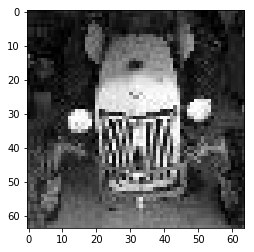

In [62]:
gray = X_train[example_index][:, :, 0]
imshow(gray, cmap='gray')

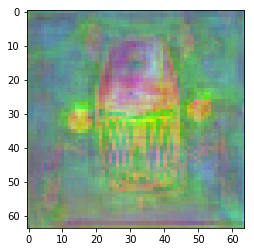

In [60]:
# visualize, after doing some shift and scaling
# because the pixel values are supposed to be between 0 and 1,
# but we don't have that from the output
im = np.zeros_like(X_train[example_index])
im[:, :, 0] = X_train[0][:, :, 0]
im[:, :, 1] = predict[:, :, 0]
im[:, :, 2] = predict[:, :, 1]
im += np.abs(np.amin(im)) + 1e-8
im /= np.amax(im)
imshow(im)

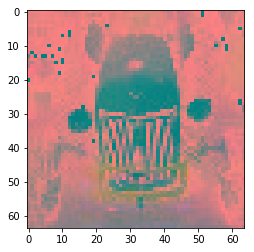

In [59]:
should_be = np.zeros_like(X_train[example_index])
should_be[:, :, 0] = X_train[0][:, :, 0]
should_be[:, :, 1] = Y_train[example_index][:, :, 0]
should_be[:, :, 2] = Y_train[example_index][:, :, 1]
should_be = should_be * undo_std + undo_mean
imshow(should_be)

In [ ]:
# here we check loss on a sample batch
bs = 64
batch = X_train[:bs]
predict = my_model.predict(batch, verbose=True)
truths = Y_train[:bs]
print(predict.shape, truths.shape)
loss_tensor = my_loss_function(tf.keras.backend.variable(predict), tf.keras.backend.variable(truths))
print(tf.keras.backend.eval(loss_tensor))
## double check by doing the calculation in pure numpy
predict_vec = np.reshape(predict, (bs, -1))
truths_vec = np.reshape(truths, (bs, -1))
all_losses = np.sum((predict_vec - truths_vec)**2, axis=1)
loss_np = np.mean(all_losses, axis=0)
print(loss_np)

32/64 [==============>...............] - ETA: 2s